# Simulation data


We simulate 100 IID data points of $T_{3}$ Copula to calculate Kendall's estimators and Test statistic mentioned in paper Copula Structure Analysis. 
We then compare the test statistic with Chi-square values with 95% confidence and find the total number of factors.

In [1]:
!pip install seaborn
!pip install yfinance
!pip install matplotlib

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import invgamma, chi2, t
import math
import yfinance as yf
import seaborn
from scipy.optimize import minimize

### Generating Test statistic 

In [3]:
# Defines required functions 

# Student T distribution Multivariate random function
# Sig - Covariance Matrix for T copula
# df - degrees of freedom for T copula
# Size - No of samples to be generated
def tMultivariate_rand(Sig, df, size):
    (m,n) = Sig.shape
    s = np.diag(Sig)
    s_not_1 = s != 1
    if any(s_not_1):
        Sig = Sig/np.sqrt(s*s.T)
    T = np.linalg.cholesky(Sig)
        
    ra = np.dot(np.random.randn(size,len(T)),T)
    x = np.sqrt(nu/chi2.rvs(df, size=size)[:, np.newaxis])
    ra = ra*x    # No need the ./x(:,ones(n,1)) as Python does elem by elem operations
    if(df>2):
        ra=ra*(df/(df-2))
    return ra

# This function generates random Student T Copula 
def tCopula_rand(Rho, nu, d, n):
    multiVar = tMultivariate_rand(Rho, d, n)
    u = stats.t.cdf(multiVar,nu)
    return u

#takes i,j and returns index of it in the vectorize function
# is used in correlation estimator matrix
def indexMappingFunc(i, j):
    index = -1
    for k in range(1,i):
        for l in range(0,k):
            index = index+1
        
    for m in range(0,j+1):
        index = index+1
    return index

# for given i, j get kendalls tau
def kendalls_tau(U, i, j, k, l):
    n,d = U.shape
    snij = 0
    snkl = 0
    snijkl = 0 
    for p in range(0, n-1):
        for q in range(0,p-1):
            snij = snij + np.sign((U[p][i]-U[q][i])*(U[p][j]-U[q][j]))
            snkl = snkl + np.sign((U[p][k]-U[q][k])*(U[p][l]-U[q][l]))
        snijkl = snijkl + (snij*snkl)

    snijkl = (snijkl/(n*(n-1)*(n-1)))
    snij = ((snij*2)/(n*(n-1)))
    snkl = ((snkl*2)/(n*(n-1)))
    return snij, snkl, snijkl

# Given a multivariate Copula matrix
# Generates kendalls estimators
def Kendalls_estimators(U):
    n,d = U.shape
    t = np.identity(d)
    dim = int((d*(d-1)/2))
    T = np.identity(dim)
    snij = 0 
    snkl = 0
    snijkl = 0
    for i in range(1,d):
        for j in range(0,i):
            for k in range(1,d):
                for l in range(0,k):
                    snij, snkl, snijkl = kendalls_tau(U, i, j, k, l)
                    #print(i, j , k , l)
                    t[i][j] = snij
                    t[j][i] = snij
                    t[k][l] = snkl
                    t[l][k] = snkl
                    a = indexMappingFunc(i,j)
                    b = indexMappingFunc(k,l)
                    T[a][b] = snijkl
                    T[b][a] = snijkl
    return t, T

#Vectorize the correlation matrix to a vector with non repeating elements
def vectorize(C):
    n,n = C.shape
    vec = []
    for i in range(1,n):
        for j in range(0,i):
            vec.append(C[i][j])
    return vec

#Devectorizes a vector to the correlation matrix with non repeating elements
def devectorize(arr):
    n = len(arr)
    d = int(np.sqrt(n*2))+1
    C = np.identity(d)
    c = 0 
    for i in range(1,d):
        for j in range(0,i):
            C[i][j] = arr[c]
            C[j][i] = arr[c]
            c = c+1
    return C

#Generate KEndalls T matrix estimate
#Returns a matrix
def Kendalls_tau_matrix(T, t, d):
    n, n = T.shape
    Testimate = np.identity(n)
    for i in range(1,d):
        for j in range(0,i):
            for k in range(1,d):
                for l in range(0,k):
                    a = indexMappingFunc(i,j)
                    b = indexMappingFunc(k,l)
                    #print(i,j,k,l,a,b)
                    Tval = T[a][b]
                    stat = (math.pi*math.pi)*math.cos(math.pi*float(t[i][j])*0.5)*math.cos(math.pi*float(t[k][l])*0.5)*(Tval - t[i][j]*t[k][l])
                    Testimate[a][b] = stat
                    Testimate[b][a] = stat
                    
    return Testimate


def generateTestStatistic(U, r):
    #Estimate kendalls tau and Kendalls estimator matrix
    #t -> Kendalls tau matrix
    #T -> Kendalls Tau based correlation estimator
    t, T = Kendalls_estimators(U)
    d, d = t.shape 
    # Calculate the optimized test statistic
    # the Kendalls tau related correlation estimator
    # r = sin(pi/2*T) where T is kendals tau matrix
    tvec = vectorize(t)
    RTau = [(math.pi)*float(i)*0.5 for i in tvec] 
    
    Testimate = Kendalls_tau_matrix(T, t, d)
    TestInv = np.linalg.inv(Testimate)
    # Quadratic descrepancy function
    # D = ((r-RTau)^T)*(T^-1)*(r-RTau)
    diff = np.array([r[i]-RTau[i] for i in range(0,len(r))])
    D = (diff).transpose()*TestInv*(diff)
    return D
    

### Simulated data

We choose a d = 10 dimensional setting with m =2 factors and loadings as given below. 
Then $LL^{T} + V^{2} = R$ is a correlation matrix.
We simulate 100 IID samples of length n = 10 of the $t_{3}$ -copula, calculate the Kendall's-${\tau}$ estimators.
Then calculate late the test statistic $T_{\tau}$ from these.
We take one factor model here - L1 as factor loadings.


In [4]:
#Copula factor model
#L -> d*m
#V ->  d*d
#R(v) = L*L^T+ V*V.  #d*d

#Taking one factor model
L1 = np.array([[0.9, 0.9, 0.9, 0.9, 0.9, 0, 0, 0, 0, 0]])
L1t = L1.transpose()
L2 = [[0.9, 0.9, 0.9, 0.9, 0.9, 0, 0, 0, 0, 0],
      [0, 0, 0, 0, 0, 0.9, 0.9, 0.9, 0.9, 0.9]]

dim=10
V = np.zeros((dim, dim))
np.fill_diagonal(V, 0.19)

#Covariance matrix 
Sig = L1*L1t + V

#number of data points
n = 50
#Degrees of freedom
nu = 3
#dimension
d = 10

r = []
#R(V) - all non repeating elements of Covariance matrix - r
for i in range(1,d):
    for j in range(0, i):
        r.append(Sig[i][j])


In [6]:
sample100 = []

#Generate 100 samples for test statistic
for i in range(0,100):
    #Generate t3 coplua with Sig as covariance matrix
    U = tCopula_rand(Sig, nu, d, n)

    #minimize test statistic and compare it with chi-square 
    #res = minimize(D, 0, method='nelder-mead')
    D = generateTestStatistic(U, r)
    sample100.append(n*D.min())

#with open('sample100.txt', 'w') as filehandle:
#    for listitem in sample100:
#        filehandle.write('%s\n' % listitem)

In the case of the one factor with m = 1 , the empirical distribution of the test statistic $T_{\tau}$  is
far off the expected $\chi^{2}_{df}$ -distribution (with df = 35 under the null hypothesis) rejecting obviously the one-factor model at almost any level of confidence level.

[-26215.73256876642, -483340.7223329153, -13887.476114458019, -49705.213687357886, -271405.58636680123, -7461.9691783989765, -492869.5546623525, -50186.542106819186, -82467.72304070528, -25369.413061898937]


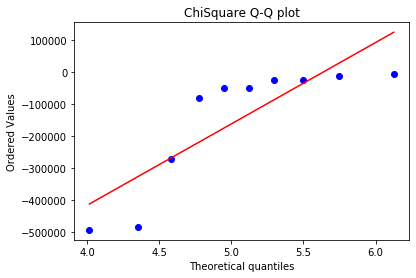

In [7]:
print(sample100)

#remove the outliers
for i in range(0,100):
    if(sample100[i] < -500000):
        sample100[i] = -100000
from statsmodels.graphics.gofplots import qqplot

stats.probplot(sample100,sparams=(26), dist=stats.chi,  plot=plt)
plt.title("ChiSquare Q-Q plot")
plt.show()

### Two-Factor simulation studies

Here we take Factor loadings as 2*10 matrix with two factors. 
We generate the Correlation matrix accordingly.

In [ ]:
#Copula factor model
#L -> d*m
#V ->  d*d
#R(v) = L*L^T+ V*V.  #d*d

#Taking one factor model
L1 = np.array([[0.9, 0.9, 0.9, 0.9, 0.9, 0, 0, 0, 0, 0]])
L1t = L1.transpose()
L2 =  np.matrix('0.9, 0.9, 0.9, 0.9, 0.9, 0, 0, 0, 0, 0; 0, 0, 0, 0, 0, 0.9, 0.9, 0.9, 0.9, 0.9')
#L2 = [[0.9, 0.9, 0.9, 0.9, 0.9, 0, 0, 0, 0, 0],
#      [0, 0, 0, 0, 0, 0.9, 0.9, 0.9, 0.9, 0.9]]
L2t = L2.transpose()

dim=10
V = np.zeros((dim, dim))
np.fill_diagonal(V, 0.19)

#Covariance matrix 
Sig = np.asarray(L2t*L2 + V)

n = 50
nu=3
d=10

r = []
#R(V) - all non repeating elements of Covariance matrix - r
for i in range(1,d):
    for j in range(0, i):
        r.append(Sig[i,j])
        
sample10 = []


#Generate 100 samples for test statistic
for i in range(0,10):
    #Generate t3 coplua with Sig as covariance matrix
    U = tCopula_rand(Sig, nu, d, n)

    #minimize test statistic and compare it with chi-square 
    #res = minimize(D, 0, method='nelder-mead')
    D = generateTestStatistic(U, r)
    print(D.min())
    sample10.append(n*D.min())

    
    
stats.probplot(sample10,sparams=(26), dist=stats.chi,  plot=plt)
plt.title("ChiSquare Q-Q plot")
plt.show()

In the case of a two-factor setting, to ensure uniqueness of the loadings, we use the restriction, that $L^{T}V^{-2}L$ is diagonal: hence we have $m(m-l)/2 = 1$ additional constraints. 

Using this restriction and the two-factor settings, $T_{\tau}$ should be $\chi_{df}^{2}$ distributed with df = d(d -1)/2 - dm + m(m-1)/2 = 26 degrees of freedom.

In [ ]:
sample50 = []

#Generate 100 samples for test statistic
for i in range(0,50):
    #Generate t3 coplua with Sig as covariance matrix
    U = tCopula_rand(Sig, nu, d, n)

    #minimize test statistic and compare it with chi-square 
    #res = minimize(D, 0, method='nelder-mead')
    D = generateTestStatistic(U, r)
    #print(D.min())
    sample50.append(n*D.min())

    
for i in range(0,50):
    sample50[i]=-sample50[i]
stats.probplot(sample50,sparams=(26), dist=stats.chi,  plot=plt)
plt.title("ChiSquare Q-Q plot")
plt.show()

In [ ]:

for i in range(0,50):
    sample50[i]=-sample50[i]
    if sample50[i]>=500000:
        sample50[i] = 200000
stats.probplot(sample50,sparams=(26), dist=stats.chi,  plot=plt)
plt.title("ChiSquare Q-Q plot")
plt.show()

In [ ]:
#for i in range(1,50):
#    sample50[i] = sample50[i]

for i in range(0,10):
    sample10[i]=-sample10[i]
    if sample10[i]>=500000:
        sample10[i] = 200000
stats.probplot(sample10,sparams=(26), dist=stats.chi,  plot=plt)
plt.title("ChiSquare Q-Q plot")
plt.show()


For the two factor model with data size as 10, 100, the Test statistic is almost aligned with the $\chi_{26}^{2}$ statistic. 
